# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make coclusions) then **text answer** is **mandatory** and **is** part of the task
* **Do not** upload the dataset to the grading system (we already have it)
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hands. 

### Task 1 <a id="task1"></a> (0.5 points)

Implement the function `H()` which calculates impurity criterion. We will be training regression tree, therefore, impurity criterion will be variance.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    return 0 if len(y) == 0 else y.var()

In [3]:
# Test the function
assert np.allclose(H(np.array([4,2,2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    r = X.T[j] < t
    l = X.T[j] >= t
    Q = len(y[r])/len(y) * H(y[r]) + len(y[l])/len(y) * H(y[l])
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'.format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def _more_tags(self):
        return {
            'requires_y': False
        }
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 
        
        for index in range(X.shape[1]):
            for row in X:
                if (Q(X, y, index, row[index]) < best_cost or best_threshold == None):
                    best_split_column, best_threshold = index, row[index]
                    X_right, X_left = X[X.T[index] >= row[index]], X[X.T[index] < row[index]]
                    y_right, y_left = y[X.T[index] >= row[index]], y[X.T[index] < row[index]]
                    best_cost = Q(X, y, index, row[index])
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth` and `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        node.prediction = np.mean(y)
        if self.is_terminal(node, y):
            node.is_terminal = True
            return
        index, t, X_l, y_l, X_r, y_r = self.best_split(X, y)
        if (index == None or len(y_l) == 0 or len(y_r) == 0):
            node.is_terminal = True
            return
        node.left = Node()
        node.right = Node()
        node.left.depth = node.depth + 1
        node.right.depth = node.depth + 1
        node.column = index
        node.threshold = t
        self.grow_tree(node.left, X_l, y_l)
        self.grow_tree(node.right, X_r, y_r)
                

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        # Check the input
        if y is None:
            raise ValueError('Y should not be None')
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        
        # Initialize the tree (root node, depth = 0)
        self.tree_ = Node()                             
        self.tree_.depth = 0                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        while (node.is_terminal == False):
            if(x[node.column] < node.threshold):
                node = node.left
            else:
                node = node.right
        y_pred = node.prediction
        return y_pred
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($70\%$) and test ($30\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

P.S. Depth of the tree is equal to the longest path from the root note to the leaf. Thus, tree with depth 1 will have exactly 1 split. 

P.P.S. Both fitted model and the training points should be on the same plot

In [8]:
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y = True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((354, 13), (152, 13), (354,), (152,))

In [9]:
model = MyDecisionTreeRegressor(max_depth = 1)
model.fit(X_train, y_train)

MyDecisionTreeRegressor(max_depth=1)

In [13]:
t = model.tree_.threshold
index = model.tree_.column
model.tree_

Col 5, t 6.94, Pred: 23.02

In [14]:
pred_l = model.tree_.left.prediction
model.tree_.left

Pred: 20.08

In [15]:
pred_r = model.tree_.right.prediction
model.tree_.right

Pred: 36.82

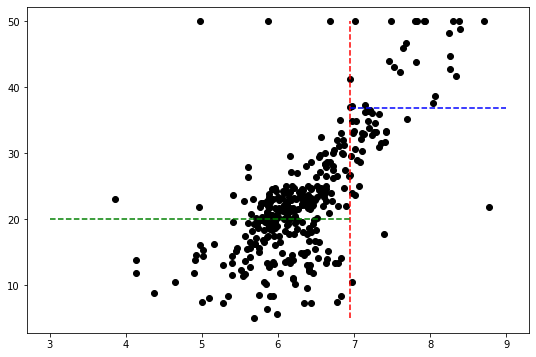

In [16]:
plt.figure(figsize=(9, 6))

plt.scatter(X_train.T[index], y_train, color='black')
plt.plot([t,t],[5,50], color = 'r',linestyle='--')
plt.plot([3,t],[pred_l,pred_l], color = 'g',linestyle='--')
plt.plot([t,9],[pred_r,pred_r], color = 'b',linestyle='--')
plt.show()

### Красная линия - критерий разделения выборки в узле

### Зеленая линия - предсказание для "левой" части выборки (x[5] < 6.94)

### Синяя линия - предсказание для "правой" части выборки (x[5] >= 6.94)

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters (`max_depth` and `min_samples_split`) on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `RMSE` on test dataset and hyperparameters of the best estimator. 

In [56]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import GridSearchCV

In [18]:
def rmse(y,y_):
    return np.sqrt(mse(y,y_))

In [117]:
%%time
params = {
    'max_depth': [i for i in range(1,11)],
    'min_samples_split': [i for i in range(1,11)]
}

clf = GridSearchCV(MyDecisionTreeRegressor(), params, scoring = 'neg_mean_squared_error', cv = 5)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)

print('Best parameters: ', clf.best_params_)
print('Predict RMSE:', rmse(y_test, predict))

Best parameters:  {'max_depth': 7, 'min_samples_split': 1}
Predict RMSE: 3.357322354615411
CPU times: user 9min 24s, sys: 3.32 s, total: 9min 27s
Wall time: 9min 51s


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias^2 and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n\_iter}$. Each $X_i$ has $N$ observations (randomly selected from the original dataset with replacement)
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n\_iter}$, which contains all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on observations from $X_i$s and compute predictions on points from $Z_i$s
4. For a given *object* $x_n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $x_n$ was in OOB)
     - variance: variance of the predictions (predictions of the algorithms, for which $x_n$ was in OOB)
5. Average bias^2 and variance over all the points


**Consider a toy example.** You are given a dataset with 5 observations: $((x_1 ,y_1), (x_2, y_2), (x_3, y_3), (x_4, y_4), (x_5, y_5))$, where $x_i$ is a vector of features, $y_i$ is a target variable . And choose `n_iter` to be 3. 
* Example of bootstrapped samples:
$$X_1 = (x_2, x_5, x_2, x_3, x_2, x_5)$$
$$X_2 = (x_5, x_2, x_4, x_4, x_1, x_5)$$
$$X_3 = (x_1, x_3, x_1, x_4, x_3, x_1)$$

* Corresponding OOB samples:
$$Z_1 = (x_1, x_4)$$
$$Z_2 = (x_3)$$
$$Z_3 = (x_2, x_5)$$

* Fit models using $X_1$, $X_2$ and $X_3$ as training data. Use 1st model to make predictions for points from $Z_1$, second - for $Z_2$, etc. and use these predictions to estimate bias and variance. 

    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations `n_iter`). All other operations should be vectorized. 

P.S. These numpy functions might be usefull here `np.nanmean`, `np.nanstd` (but you are not obliged to use them). 

In [21]:
import random

In [148]:
def f(row, idx):
    if(int(row) not in idx):
        return row

In [230]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias^2 and variance of the `estimator`. Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    data = pd.DataFrame(x)
    data[-1] = y
    data['index'] = list(range(data.shape[0]))
    predictions_test = np.empty((len(x), 1))
    predictions_test[:] = np.nan
    for i in range(n_iter):
        train_idx = np.random.randint(0, data.shape[0] , int(data.shape[0]))
        train_data = data.loc[train_idx,:]
        test_idx = data['index'].apply(lambda row: f(row, train_idx))
        test_idx = list(test_idx[test_idx.isna() == False].astype('int32'))
        test_data = data.loc[test_idx,:]
        X_ = np.array(train_data.loc[:,:-1])
        y_ = train_data.loc[:,-1]
        model = estimator.fit(X_, y_)
        prediction = model.predict(np.array(test_data.loc[:,:-1]))
        pred = np.empty(len(x))
        pred[:] = np.nan
        np.put(pred, test_idx, prediction)
        predictions_test = np.column_stack((predictions_test, pred)) 
    predictions_test = np.delete(predictions_test, 1, axis = 1)
    y_test_predict_mean = np.nanmean(predictions_test, axis = 1)
    var = np.nanvar(predictions_test, axis = 1)
    bias2 = (y - y_test_predict_mean) ** 2
    return np.nanmean(bias2), np.nanmean(var)

In [231]:
%%time
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)

CPU times: user 17.8 s, sys: 171 ms, total: 17.9 s
Wall time: 18.7 s


<ipython-input-230-0d3f9a832bd8>:40: RuntimeWarning: Mean of empty slice
  y_test_predict_mean = np.nanmean(predictions_test, axis = 1)
<ipython-input-230-0d3f9a832bd8>:41: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = np.nanvar(predictions_test, axis = 1)


(0.3201549233988078, 0.13351599589359214)

### Task 7 <a id="task7"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Compute bias and variance for the trees of different depths. Plot how bias and variance change as depth increases. 

Comment on what you observe, how does your result correspond to what we have discussed in class?

<ipython-input-230-0d3f9a832bd8>:40: RuntimeWarning: Mean of empty slice
  y_test_predict_mean = np.nanmean(predictions_test, axis = 1)
<ipython-input-230-0d3f9a832bd8>:41: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = np.nanvar(predictions_test, axis = 1)
<ipython-input-230-0d3f9a832bd8>:40: RuntimeWarning: Mean of empty slice
  y_test_predict_mean = np.nanmean(predictions_test, axis = 1)
<ipython-input-230-0d3f9a832bd8>:41: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = np.nanvar(predictions_test, axis = 1)
<ipython-input-230-0d3f9a832bd8>:40: RuntimeWarning: Mean of empty slice
  y_test_predict_mean = np.nanmean(predictions_test, axis = 1)
<ipython-input-230-0d3f9a832bd8>:41: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = np.nanvar(predictions_test, axis = 1)
<ipython-input-230-0d3f9a832bd8>:40: RuntimeWarning: Mean of empty slice
  y_test_predict_mean = np.nanmean(predictions_test, axis = 1)
<ipython-input-230-0d3f9a832bd8>:41: RuntimeWarning: D

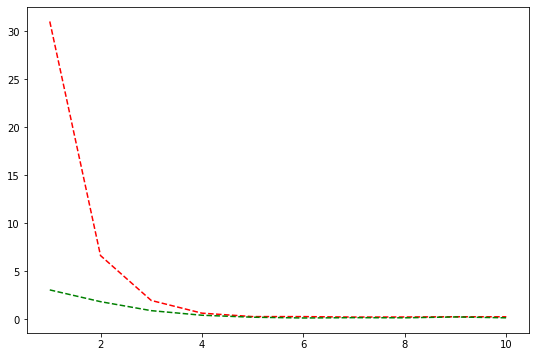

In [236]:
labels = list(range(1,11))
bias2 = []
var = []
for i in range(1,11):
    #print(i)
    estimator = MyDecisionTreeRegressor(max_depth=i, min_samples_split=3)
    res = get_bias_variance(estimator, X_train, y_train, 10)
    bias2.append(res[0])
    var.append(res[1])
    
plt.figure(figsize=(9, 6))
plt.plot(labels,bias2, color = 'r',linestyle='--')
plt.plot(labels,var, color = 'g',linestyle='--')
plt.show()

Смещение (красная линия) стремительно уменьшается с увеличением глубины. Все верно - точность модели увеличивается с увеличеснием глубины.

Разброс (зеленая линия) - должен увеличиватсья вместе с глубиной. Но этого не происходит.

### Task 8 <a id="task8"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [238]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor(base_estimator=MyDecisionTreeRegressor(max_depth=8, min_samples_split=15), n_estimators= 12, random_state=12345)

get_bias_variance(model, X_train, y_train, n_iter=10)

<ipython-input-230-0d3f9a832bd8>:40: RuntimeWarning: Mean of empty slice
  y_test_predict_mean = np.nanmean(predictions_test, axis = 1)
<ipython-input-230-0d3f9a832bd8>:41: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = np.nanvar(predictions_test, axis = 1)


(0.2672196123947847, 0.059609328624241016)

- В теории bagging должен уменьшать дисперсию и не увеличивать смещение (не менятть его)
- Дисперсия уменьшилась в 2,6 раза. Разброс тоже уменьшился, но незначительно
- В целом результаты совпадают с теорией, за исключением незначительного уменьшения смещения (изменение около 15%) и то в сторону увеличения точности модели

Свою задачу bagging выполняет

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [4]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


In [5]:
X.shape

(3772, 29)

### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (take a look at the argument `drop` in [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to figure out the best way to apply OHE to binary variables)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer)) to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transorm1, column_names1),
    ('name2', transorm2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_transform = make_pipeline(
                                 transform_1,
                                 transform_2
                                )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns in the dataset. 

In [86]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


cols_to_drop = X.columns[X.isna().sum()/X.shape[0] > 1/3]

X = X.drop(list(cols_to_drop), axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 12345)

category_pipline = Pipeline(
    steps = [('fillna', SimpleImputer(strategy='most_frequent')),
             ('encode', OneHotEncoder())
            ]
)

category_cols = (X.dtypes == 'O').to_list()
float_cols = (X.dtypes == 'float64').to_list()

transformer = ColumnTransformer(
    transformers=[
        ('category', category_pipline, category_cols),
        ('float', SimpleImputer(strategy='median'), float_cols)
    ], remainder='passthrough')

# Transform the data
X_train = transformer.fit_transform(X_train)
X_test = transformer.transform(X_test)

In [87]:
X_train.shape, X_test.shape

((2514, 52), (1258, 52))

### Task 2 <a id="task2_2"></a> (0.7 points  = 0.4 for code + 0.3 for comments)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [88]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

In [89]:
pd.DataFrame(y_train).value_counts() / pd.DataFrame(y_train).shape[0] * 100

0    93.993636
1     6.006364
dtype: float64

Распределение классов в тренировочной выборке очень неравномерное (94% vs 6%). Использовать простую метрику (как accuracy) не получится - следует использовать метрику использующую полноту и точность (recall и precision) для адекватной оценки предсказания. Я буду использовать f1 меру, так как она ассимирует обе эти метрики в себе.

In [90]:
cv = StratifiedKFold(n_splits = 5)

## RandomForestClassifier

In [91]:
forest = RandomForestClassifier(random_state = 12345)

cvs = cross_val_score(forest, X_train, y_train, cv = cv, scoring = 'f1')
cvs

array([0.8       , 0.82352941, 0.89285714, 0.85245902, 0.87272727])

По блокам значение колеблится не слишком сильно.

In [83]:
print(f'RandomForestClassifier: Train {cvs.mean():.3f}; Test {f1_score(y_test,forest.fit(X_train, y_train).predict(X_test)):.3f}')

RandomForestClassifier: Train 0.834; Test 0.884


Для случайного леса значение метрики на тесте и на трейне отличается. Можно есть небольшое недообучение.

## GradientBoostingClassifier

In [92]:
grad = GradientBoostingClassifier(random_state = 12345)

cvs = cross_val_score(grad, X_train, y_train, cv = cv, scoring = 'f1')
cvs

array([0.89285714, 0.83018868, 0.94915254, 0.80645161, 0.88135593])

In [93]:
print(f'GradientBoostingClassifier: Train {cvs.mean():.3f}; Test {f1_score(y_test,grad.fit(X_train, y_train).predict(X_test)):.3f}')

GradientBoostingClassifier: Train 0.872; Test 0.870


В бустинге колебания между фолдами более значительные. Но отличие метрики на трейне и тесте очень небольшое. Переобучения нет.

## DecisionTreeClassifier

In [94]:
tree = DecisionTreeClassifier(random_state = 12345)

cvs = cross_val_score(tree, X_train, y_train, cv = cv, scoring = 'f1')
cvs

array([0.83636364, 0.82142857, 0.87096774, 0.86153846, 0.89655172])

In [95]:
print(f'DecisionTreeClassifier: Train {cvs.mean():.3f}; Test {f1_score(y_test,tree.fit(X_train, y_train).predict(X_test)):.3f}')

DecisionTreeClassifier: Train 0.857; Test 0.867


Дерево решений неплохо предсказывает, значительных различий на трейне и тесте нет.

## LogisticRegression

In [34]:
log_reg = LogisticRegression(random_state = 12345, max_iter=10000)

cvs = cross_val_score(log_reg, X_train, y_train, cv = cv, scoring = 'f1')
cvs

array([0.73684211, 0.54545455, 0.77777778, 0.53061224, 0.66666667])

In [35]:
print(f'LogisticRegression: Train {cvs.mean():.3f}; Test {f1_score(y_test,log_reg.fit(X_train, y_train).predict(X_test)):.3f}')

LogisticRegression: Train 0.651; Test 0.662


При обучении логистической регресии возникла проблема - алгоритм не сходился. Пришлось увеличить кол-во итераций в 100 раз.

Однако колебания метрики между фолдами наталкивает на мысль что алгоритм не всегда находит глобальный оптимум и застревает в локальном минимуме. Метрика на трейне и тесте отличается не сильно (хотя само значение достаточно мало п осравнению с другими алгоритмами).

## Метод опорных векторов

In [51]:
svc_ = SVC(random_state = 12345, kernel = 'linear')

cvs = cross_val_score(svc_, X_train, y_train, cv = cv, scoring = 'f1')
cvs

array([0.79245283, 0.60869565, 0.80701754, 0.57692308, 0.71428571])

In [52]:
print(f'SVC: Train {cvs.mean():.3f}; Test {f1_score(y_test,svc_.fit(X_train, y_train).predict(X_test)):.3f}')

SVC: Train 0.700; Test 0.696


Я использую svc с линейным ядром потому что с другими ядрами алгоритм начинал предсказывать как константный и recall обнулялся.

Тем не менее значения метрики на разных фолдах сильно скачет, да и метрика не тесте достаточно низкая. 

Бустинг ожидаемо становится лучшей моделью с самым большим значением метрики на тесте и самым маленьким отклонением метрики на трейне и на тесте.

### Task 3 <a id="task2_3"></a> (0.5 points = 0.4 for code + 0.1 for comments)

More Gradient Boosting. Choose one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 



In [54]:
from lightgbm import LGBMClassifier

In [62]:
%%time
model = LGBMClassifier(random_state = 12345)

params = {
    'max_depth': list(range(2, 11)),
    'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4],
    'n_estimators': list(range(30, 121, 5))
}

clf = GridSearchCV(model, params, scoring = 'f1', cv = cv)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)

print('Best parameters & score: ', clf.best_params_, clf.best_score_)
print('Predict f1:', f1_score(y_test, predict))

Best parameters & score:  {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 50} 0.89777356285081
Predict f1: 0.8662420382165604
Wall time: 5min 30s


Перебор гиперпараметров дал нам точность предсказания почти 0.9 на стратифицированной кросс валидации.
Предсказание на тестовой выборке осталось примерно на том же уровне точности.

Вывод: если соотношение классов сохраняется в тесте то мы подобрали хорошие гиперпараметры и можем предсказать со значением метрики около 0.9

Но наш тест выбран случайным образом без сохранения распределения классов, и тем не менее точность предсказания достаточно высока. Возможно есть небольшое переобучение, но найденая конфигурация алгоритма вполне сносна.

### Task 4 <a id="task2_4"></a> (0.7 points = 0.4 for code + 0.3 for comments)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting as base estimators (use large amount of trees in gradient boosting, >100)
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfitting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

## Bagging & decision tree

In [96]:
from sklearn.ensemble import BaggingClassifier

model = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state = 12345, max_depth=10, min_samples_split = 10), random_state=12345)

In [102]:
%%time

params = {
    'n_estimators': list(range(2, 101)),
}

clf = GridSearchCV(model, params, scoring = 'f1', cv = cv)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)

print('Best parameters & score: ', clf.best_params_, clf.best_score_)
print('Predict f1:', f1_score(y_test, predict))

Best parameters & score:  {'n_estimators': 65} 0.8788873736389808
Predict f1: 0.8903225806451613
Wall time: 25.6 s


Bagging творит чудеса. Даже на обычном решающем дереве удалось получить достаточно высокие значения метрики, при этом обобщающая способность модели выросла значительно. Предсказание на тестовой выборке дало точность как лучшая модель бустинга из прошлых пунктов.

## Bagging & gradient boosting

In [112]:
model = BaggingClassifier(base_estimator= GradientBoostingClassifier(random_state = 12345,learning_rate = 0.2, max_depth = 10, n_estimators = 120), random_state=12345)

In [115]:
%%time

params = {
    'n_estimators': list(range(2, 10)),
}

clf = GridSearchCV(model, params, scoring = 'f1', cv = cv)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)

print('Best parameters & score: ', clf.best_params_, clf.best_score_)
print('Predict f1:', f1_score(y_test, predict))

Best parameters & score:  {'n_estimators': 7} 0.8689505124819217
Predict f1: 0.8765432098765432
Wall time: 1min 23s


Bagging увеличил обобщающую способность бустинга. Переобучения нет, предсказание на тесте выше чем на тренировочных данных.

## VotingClassifier (Gradient & Bagging DecisionTree & RandomForest)

In [116]:
from sklearn.ensemble import VotingClassifier

In [118]:
clf1 = GradientBoostingClassifier(random_state = 12345,max_depth = 10)
clf2 = BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state = 12345, max_depth=10, min_samples_split = 10), random_state=12345)
clf3 = RandomForestClassifier(random_state = 12345)

vot_model = VotingClassifier(estimators=[ ('grad', clf1), ('tree', clf2),('forest', clf3)], voting='hard')
params = {'grad__n_estimators' : list(range(20,40,2)),
          'tree__n_estimators' : list(range(5, 21)), 
          'forest__criterion' : ['gini', 'entropy']}

clf = GridSearchCV(vot_model, params, scoring = 'f1', cv = cv)
clf.fit(X_train, y_train)
predict = clf.predict(X_test)

print('Best parameters & score: ', clf.best_params_, clf.best_score_)
print('Predict f1:', f1_score(y_test, predict))

Best parameters & score:  {'forest__criterion': 'gini', 'grad__n_estimators': 20, 'tree__n_estimators': 6} 0.8756830089063079
Predict f1: 0.8805031446540881


## Stacking Classifier &  Logistic Regression as final

In [119]:
from sklearn.ensemble import StackingClassifier

In [127]:
model_ = StackingClassifier(
         estimators=[ ('grad', clf1), ('tree', clf2),('forest', clf3)], final_estimator=LogisticRegression(random_state=12345)
)

model_.fit(X_train, y_train)
predict = model_.predict(X_test)
print('Predict f1 train:', f1_score(y_train, model_.predict(X_train)))
print('Predict f1 test:', f1_score(y_test, predict))

Predict f1 train: 1.0
Predict f1 test: 0.8805031446540881


## Stacking Classifier &  Gradeint Boosting as final

In [124]:
model = StackingClassifier(
         estimators=[ ('grad', clf1), ('tree', clf2),('forest', clf3)], final_estimator=GradientBoostingClassifier(random_state=12345)
)

model.fit(X_train, y_train)
predict = model.predict(X_test)
print('Predict f1 train:', f1_score(y_train, model.predict(X_train)))
print('Predict f1:', f1_score(y_test, predict))

Predict f1 train: 0.9310344827586207
Predict f1: 0.8235294117647058


Ответы на вопросы:
- Лучшее качетсво предсказания показала Stacking Classifier(Logistic Regression). F1 мера на трейне составила 1 - то есть полное отображение тренировочный выборки в ответы. На тестовой выборке метрика стоставила бы 0.88
- Bagging увеличил обобщающую способность бустинга. Переобучения нет, предсказание на тесте выше чем на тренировочных данных.
- VotingClassifier использует несколько моделей для предсказания, а итоговый ответ алгоритма формируется из большинства голосов моделей (hard). Stacking Classifier тоже использует несколько моделей для предсказания, но использует их предсказания для обучения финальной модели (final_model) и в качестве ответа выдает предсказание финальной модели.

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to get on this dataset. 

In [128]:
print('Test f1-score:', f1_score(y_test, model_.predict(X_test)))
model_

Test f1-score: 0.8805031446540881


StackingClassifier(estimators=[('grad',
                                GradientBoostingClassifier(max_depth=10,
                                                           random_state=12345)),
                               ('tree',
                                BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10,
                                                                                        min_samples_split=10,
                                                                                        random_state=12345),
                                                  random_state=12345)),
                               ('forest',
                                RandomForestClassifier(random_state=12345))],
                   final_estimator=LogisticRegression(random_state=12345))